In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
import CCE 
from likelihood_funcs import * 
import corner
import scipy

from scipy.interpolate import InterpolatedUnivariateSpline as spline

In [2]:
id = "0001"

sim_main = CCE.SXS_CCE(id, lev="Lev5", radius="R2")
sim_options = [("Lev4", "R2"), ("Lev4", "R3"), ("Lev5", "R3")]

sims = []

for lev, R in sim_options:
    try:
        sim = CCE.SXS_CCE(id, lev=lev, radius=R)
        sims.append(sim)
    except:
        pass

In [3]:
def data_mismatch(sim1, sim2, t0=0, modes=None, T=100, dt=0.01, shift=0):

    """
    
    This is only used to perform a general timeshift between the two simulations

    """

    new_times = np.arange(t0, t0 + T, dt)

    if modes is None:
        modes = list(sim1.h.keys())

    numerator = 0.0
    denominator1 = 0.0
    denominator2 = 0.0

    for mode in modes:

        h1 = sim1.h[mode]
        h2 = sim2.h[mode]

        #TODO do we still need these interpolators?

        interp_h1 = np.interp(new_times, sim1.times, h1)
        interp_h2 = np.interp(new_times - shift, sim2.times, h2)

        numerator += np.abs(np.trapz(interp_h1 * np.conjugate(interp_h2), x=new_times))
        denominator1 += np.abs(
            np.trapz(interp_h1 * np.conjugate(interp_h1), x=new_times)
        )
        denominator2 += np.abs(
            np.trapz(interp_h2 * np.conjugate(interp_h2), x=new_times)
        )

    denominator = np.sqrt(denominator1 * denominator2)

    return 1 - (numerator / denominator)

In [4]:
# Perform a time shift 

for i, sim in enumerate(sims):
    shifts = np.arange(-0.1, 0.1, 0.0001)
    # TODO: Review whether angle averaged mismatch is the best way to find the shift; it takes too long at the moment 
    shift_idx = np.argmin([data_mismatch(sim_main, sim, modes=None, shift=s) for s in shifts])
    sims[i].zero_time = -shifts[shift_idx]
    sims[i].time_shift()

In [418]:
l_max = 2
n_max = 1

t0 = 0
T = 100

analysis_mask = (sim_main.times >= t0 - 1e-9) & (sim_main.times < t0+T - 1e-9)
analysis_times = sim_main.times[analysis_mask]

qnm_list = [(ell,2,n,1) for ell in np.arange(2, l_max+1) for n in np.arange(0, n_max+1)]
spherical_modes = [(ell, 2) for ell in np.arange(2, l_max+1)]

#qnm_list = [(ell,m,n,p) for ell in np.arange(2, l_max+1) for m in np.arange(-ell, ell+1) for n in np.arange(0, n_max+1) for p in [-1,1]]
#spherical_modes = [(ell, m) for ell in np.arange(2, l_max+1) for m in np.arange(-ell, ell+1)]

#qnm_list = [(ell,2,n,1) for ell in [2,3] for n in [0,1]]
#spherical_modes = [(2,2), (3,2)]

chif_mag_0 = sim_main.chif_mag
Mf_0 = sim_main.Mf

# remove m = 0 modes 
#qnm_list = [qnm for qnm in qnm_list if qnm[1] != 0]
#spherical_modes = [mode for mode in spherical_modes if mode[1] != 0]

print(len(qnm_list))

2


In [419]:
param_list = [qnm for qnm in qnm_list for _ in range(2)] 

ls_fit = qnmfits.multimode_ringdown_fit(
    sim_main.times,
    sim_main.h,
    modes=qnm_list,
    Mf=Mf_0,
    chif=chif_mag_0,
    t0=t0,
    T=T,
    spherical_modes=spherical_modes,
)

ls_c = ls_fit['C']

true_as = []
for re_c, im_c in zip(np.real(ls_fit['C']), np.imag(ls_fit['C'])):
    true_as.append(re_c)
    true_as.append(im_c)

true_params = true_as

In [420]:
# Interpolate the waveforms to the same times as the 'main' simulation 

sims_interp = []

for i, sim in enumerate(sims):
    sim_interp = {}
    for ell, m in sim.h.keys():
        sim_interp[ell,m] = spline(sim.times, np.real(sim.h[ell,m]), ext=1)(sim_main.times) + \
        1j*spline(sim.times, np.imag(sim.h[ell,m]), ext=1)(sim_main.times)
    sims_interp.append(sim_interp)

In [421]:
# Compute the difference in levels 

R = {}

# TODO: Search all levels/radii or just choose one? And is sum the best measure for the 'worst'? 

for i, sim in enumerate(sims_interp):
    for ell, m in spherical_modes:
        diff = sim_main.h[ell,m] - sim[ell,m]
        if (ell, m) not in R.keys() or np.abs(np.sum(diff)) > np.abs(np.sum(R[ell,m])):
            R[ell,m] = diff 

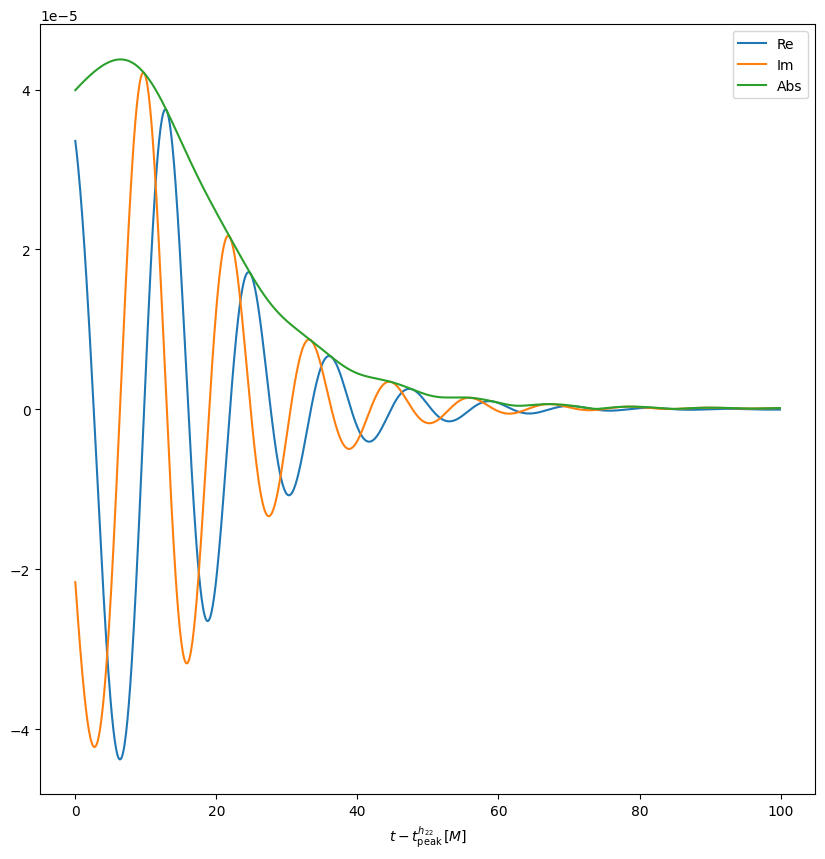

In [422]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(sim_main.times[analysis_mask], np.real(R[2,2])[analysis_mask], label='Re')
ax.plot(sim_main.times[analysis_mask], np.imag(R[2,2])[analysis_mask], label='Im')
ax.plot(sim_main.times[analysis_mask], np.abs(R[2,2])[analysis_mask], label='Abs')

#axs[i].set_ylabel(f'$h_{{{ell}{m}}}^\mathrm{{Lev{sim.highest_lev}}} - h_{{{ell}{m}}}^\mathrm{{Lev{sim.highest_lev-1}}}$')
#axs[i].set_title(rf'$\ell = {ell},\, m = {m}$')

ax.set_xlabel('$t-t_\mathrm{peak}^{h_{22}}\, [M]$')

ax.legend();

In [423]:
# Determine the amplitude of the residual 

residual_amplitudes = {}

for ell, m in R.keys():
    residual_amplitudes[(ell, m)] = np.max(np.abs(R[ell, m][analysis_mask]))


In [424]:
def smooth_ceil(t, t_max):
    return t / np.sqrt(1 + (t/t_max)**2)

def old_func(t, length_scale, t_s, t_min, t_max):
    return smooth_ceil(exponential_func(t, length_scale, t_s), t_max) - t_min

In [545]:
def squared_exp_element(t1, t2, sigma_max, period):
    time_diff = np.abs(t1[:, None] - t2[None, :])
    return sigma_max**2 * np.exp(-0.5 * time_diff**2 / period**2) 

def logoneplusexp(t):
    return np.log(1 + np.exp(-np.abs(t))) + np.maximum(t, 0)

def smoothclip(t, t_min, t_max, t_scale, sharpness):
    return ((t/t_scale) - 
            (1./sharpness)*logoneplusexp(sharpness*((t/t_scale) - t_max)) + 
            (1./sharpness)*logoneplusexp(-sharpness*((t/t_scale) - t_min))
    )

def exponential_func(t, length_scale, t_s):
    return np.exp(-(t-t_s)/length_scale)

def new_func(t, length_scale, t_s, t_min, t_max, t_scale, sharpness):
    t = np.asarray(t)
    return smoothclip(exponential_func(t, length_scale, t_s), t_min, t_max, t_scale, sharpness)

def kernel(analysis_times, **kwargs):
    t1 = analysis_times
    t2 = analysis_times
    return (
        squared_exp_element(t1, t2, kwargs['sigma_max'], kwargs['period'])
        * new_func(t1, kwargs['length_scale'], kwargs['t_s'], kwargs['t_min'], kwargs['t_max'], kwargs['t_scale'], kwargs['sharpness'])[:, None]
        * new_func(t2, kwargs['length_scale'], kwargs['t_s'], kwargs['t_min'], kwargs['t_max'], kwargs['t_scale'], kwargs['sharpness'])[None, :]
    )

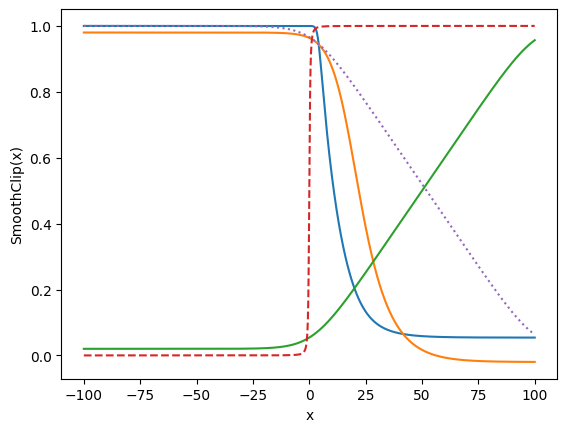

In [546]:
x = np.linspace(-100, 100, 10000)

x_max, x_min  = 0.9, 0.1

fig, ax = plt.subplots()
ax.plot(x, new_func(x, length_scale=10, t_s=50, t_min=0.02, t_max=1, t_scale=100, sharpness=16))
ax.plot(x, old_func(x, length_scale=10, t_s=17, t_min=0.02, t_max=1))
ax.plot(x, smoothclip(x, t_min=0.02, t_max=1, t_scale=100, sharpness=16))
ax.plot(x, smooth_ceil(x, t_max=0.5) + 0.5, ls='--')
ax.plot(x, smoothclip(x, t_min=1, t_max=0.02, t_scale=100, sharpness=16), ls=':')
#ax.plot(x, exponential_func(x, length_scale=10, t_s=17))
ax.set_xlabel('x')
ax.set_ylabel('SmoothClip(x)')
plt.show()

In [579]:
# Kernel parameters

qnm_decay_time = {}
qnm_lambda = {}

hyperparam_dict = {}
for ell, m in spherical_modes:
    omega = qnmfits.qnm.omega(ell, m, 0, 1, sim_main.chif_mag, sim_main.Mf)
    tau_scale = 1
    lam_scale = 2 # Note in the limit of very small lam_scale, the kernel agrees with identity 
    hyperparam_dict[ell,m] = {
        'sigma_max': residual_amplitudes[ell,m],
        't_max': 1,
        't_min': 0.2,
        't_s': 68,
        't_scale': 100,
        'sharpness': 16,
        'length_scale': -1/omega.imag * tau_scale,
        'period': (2*np.pi)/omega.real * lam_scale
    }

In [580]:
"""
kernel_dict = {} 
n_times = len(analysis_times)

for (ell, m) in spherical_modes:
    kernel_matrix = np.zeros((n_times, n_times))
    for i in range(n_times):
        for j in range(i, n_times):
            kernel_matrix[i, j] = kernel(analysis_times[i], analysis_times[j], **hyperparam_dict[ell,m])
            if i != j:
                kernel_matrix[j, i] = kernel_matrix[i, j]

    kernel_matrix += np.eye(n_times) * 1e-14
    kernel_dict[(ell, m)] = kernel_matrix
""" 

'\nkernel_dict = {} \nn_times = len(analysis_times)\n\nfor (ell, m) in spherical_modes:\n    kernel_matrix = np.zeros((n_times, n_times))\n    for i in range(n_times):\n        for j in range(i, n_times):\n            kernel_matrix[i, j] = kernel(analysis_times[i], analysis_times[j], **hyperparam_dict[ell,m])\n            if i != j:\n                kernel_matrix[j, i] = kernel_matrix[i, j]\n\n    kernel_matrix += np.eye(n_times) * 1e-14\n    kernel_dict[(ell, m)] = kernel_matrix\n'

In [581]:
kernel_dict = {} 
n_times = len(analysis_times)

for (ell, m) in spherical_modes:
    kernel_dict[(ell, m)] = kernel(np.asarray(analysis_times), **hyperparam_dict[ell,m]) + np.eye(len(analysis_times)) * 1e-14

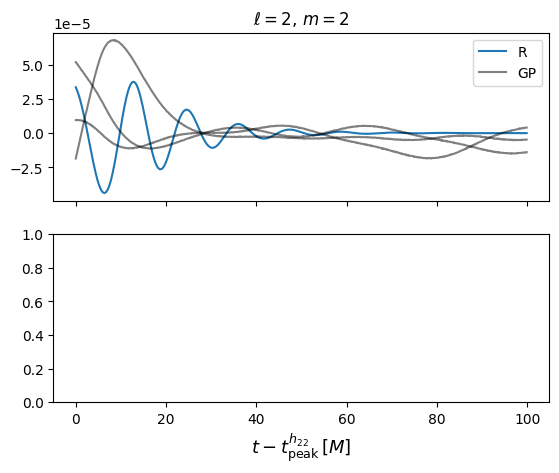

In [582]:
rng = np.random.default_rng()

fig, axs = plt.subplots(len(spherical_modes)+1, 1, sharex=True)

for i, (ell,m) in enumerate(spherical_modes):

    axs[i].plot(sim_main.times[analysis_mask], np.real(R[ell,m])[analysis_mask], label='R')

    repeats = 3
    gp_samples = rng.multivariate_normal(np.zeros(n_times), kernel_dict[ell,m], size=repeats)
    for j, draw in enumerate(gp_samples):
        label = 'GP' if j == 0 else None
        axs[i].plot(analysis_times, draw, color='black', alpha=0.5, label=label)

    axs[i].set_title(rf'$\ell = {ell},\, m = {m}$')

axs[-1].set_xlabel('$t-t_\mathrm{peak}^{h_{22}}\, [M]$', fontsize=13)

axs[0].legend();

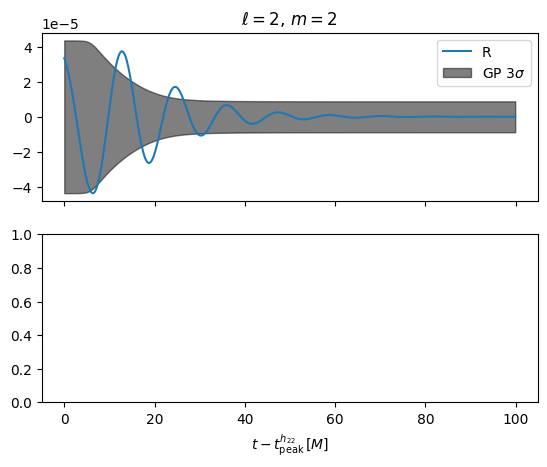

In [583]:
fig, axs = plt.subplots(len(spherical_modes)+1, 1, sharex=True)

for i, (ell,m) in enumerate(spherical_modes):

    axs[i].plot(sim_main.times[analysis_mask], np.real(R[ell,m])[analysis_mask], label='R')
    #axs[i].plot(ls_fit['model_times'], ls_fit['model'][(2,2,0,1)], label='R')

    # Plot the 1-sigma credible region of the GP
    axs[i].fill_between(
        analysis_times, 
        -np.sqrt(np.diag(kernel_dict[ell,m])), 
        np.sqrt(np.diag(kernel_dict[ell,m])),
        color='black', 
        alpha=0.5,
        label='GP 3$\sigma$'
        );

    axs[i].set_title(rf'$\ell = {ell},\, m = {m}$')

axs[-1].set_xlabel('$t-t_\mathrm{peak}^{h_{22}}\, [M]$')

axs[0].legend();

In [584]:
kernel_dict_inv = {(ell,m): np.linalg.inv(kernel_dict[ell,m]) for ell,m in spherical_modes}

# Convert kernel_dict_inv to a matrix
kernel_matrix_inv = np.zeros((len(spherical_modes), n_times, n_times), dtype=np.complex128)

for idx, (ell, m) in enumerate(spherical_modes):
    kernel_matrix_inv[idx, :, :] = kernel_dict_inv[(ell, m)]

In [585]:
"""
def compute_kernel_matrix(analysis_times, hyperparams):
    n_times = len(analysis_times)

    kernel_matrix = np.zeros((n_times, n_times))
    for i in range(n_times):
        for j in range(i, n_times):
            kernel_matrix[i, j] = kernel(analysis_times[i], analysis_times[j], **hyperparams)
            if i != j:
                kernel_matrix[j, i] = kernel_matrix[i, j]

    kernel_matrix += np.eye(n_times) * 1e-13
    return kernel_matrix

"""

'\ndef compute_kernel_matrix(analysis_times, hyperparams):\n    n_times = len(analysis_times)\n\n    kernel_matrix = np.zeros((n_times, n_times))\n    for i in range(n_times):\n        for j in range(i, n_times):\n            kernel_matrix[i, j] = kernel(analysis_times[i], analysis_times[j], **hyperparams)\n            if i != j:\n                kernel_matrix[j, i] = kernel_matrix[i, j]\n\n    kernel_matrix += np.eye(n_times) * 1e-13\n    return kernel_matrix\n\n'

In [586]:
def compute_kernel_matrix(analysis_times, hyperparams):
    return kernel(np.asarray(analysis_times), **hyperparams) + np.eye(len(analysis_times)) * 1e-13

In [587]:
# determine log Z as a function of the hyperparameters 

def log_evidence(K, f):
    _, logdet = np.linalg.slogdet(K)
    return -0.5 * np.dot(f, np.linalg.solve(K, f)) - 0.5 * logdet - 0.5 * len(f) * np.log(2 * np.pi)

# Compute log evidence for a range of parameters

def log_evidence_range(R, param, analysis_times, analysis_mask, hyperparam_dict, spherical_mode = (2,2), n_values = 10):
    f = R[spherical_mode][analysis_mask]
    hyperparam_dict_new = hyperparam_dict[spherical_mode].copy()
    param_value = hyperparam_dict_new[param]
    values = np.linspace(0.1, 4, n_values)
    log_evidence_values = np.zeros(n_values)
    for i, value in enumerate(values):
        hyperparam_dict_new[param] = value * param_value
        K = compute_kernel_matrix(analysis_times, hyperparam_dict_new)
        log_evidence_values[i] = log_evidence(K, f)
    return values, log_evidence_values

sigma_max


/tmp/ipykernel_788255/1709685542.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  log_evidence_values[i] = log_evidence(K, f)


t_max
t_min
t_s
t_scale
sharpness
length_scale
period


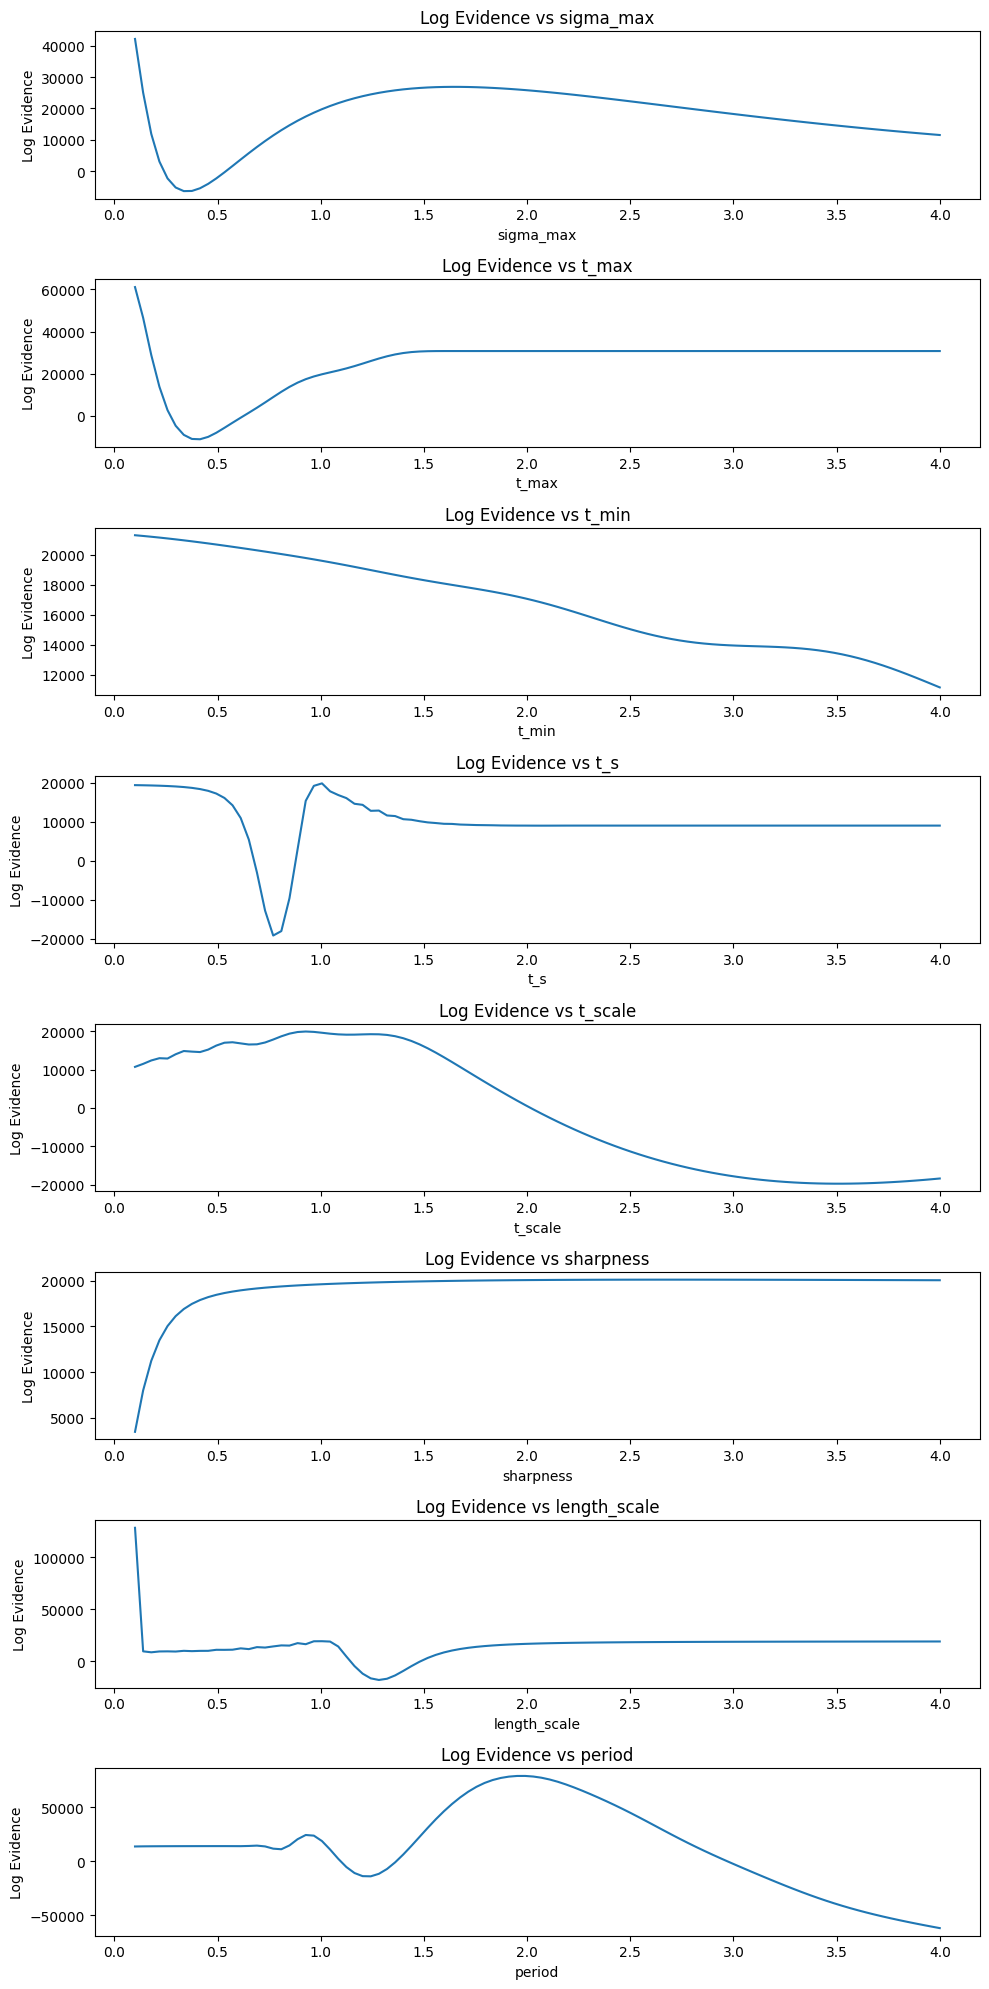

In [588]:
fig, axs = plt.subplots(len(hyperparam_dict[(2, 2)]), 1, figsize=(10, 20))

for i, param in enumerate(hyperparam_dict[(2, 2)].keys()):
    print(param)
    values, log_evidence_values = log_evidence_range(R, param, analysis_times, analysis_mask, hyperparam_dict, n_values=100)
    axs[i].plot(values, log_evidence_values)
    axs[i].set_title(f'Log Evidence vs {param}')
    axs[i].set_xlabel(param)
    axs[i].set_ylabel('Log Evidence')

plt.tight_layout()
plt.show()

In [589]:
FIXED_SIGMA = 1e-5

test_kernel_inv = np.array([np.eye(n_times) for _ in spherical_modes]) /  FIXED_SIGMA**2

fisher_matrix_full = get_fisher_matrix(qnm_list, spherical_modes, sim_main.times, Mf_0, chif_mag_0, kernel_matrix_inv)  
b_vec_full = get_b_vector(qnm_list, spherical_modes, t0, sim_main.times, sim_main.h, Mf_0, chif_mag_0, kernel_matrix_inv)

fisher_matrix_id = get_fisher_matrix(qnm_list, spherical_modes, sim_main.times, Mf_0, chif_mag_0, test_kernel_inv)
b_vec_id = get_b_vector(qnm_list, spherical_modes, t0, sim_main.times, sim_main.h, Mf_0, chif_mag_0, test_kernel_inv)

fisher_matrix_1 = get_fisher_matrix(qnm_list, spherical_modes, sim_main.times, Mf_0, chif_mag_0, FIXED_SIGMA)
b_vec_1 = get_b_vector(qnm_list, spherical_modes, t0, sim_main.times, sim_main.h, Mf_0, chif_mag_0, FIXED_SIGMA)

Precomputation time:  0.00024080276489257812
Fisher matrix computation time:  0.02462148666381836
Precomputation time:  0.00023436546325683594
Fisher matrix computation time:  0.02700209617614746
Precomputation time:  0.00020813941955566406
Fisher matrix computation time:  0.00017189979553222656


In [590]:
mean_vector_full = np.linalg.solve(fisher_matrix_full, b_vec_full)
mean_vector_id = np.linalg.solve(fisher_matrix_id, b_vec_id)
mean_vector_1 = np.linalg.solve(fisher_matrix_1, b_vec_1)

covariance_matrix_full = np.linalg.inv(fisher_matrix_full)
covariance_matrix_id = np.linalg.inv(fisher_matrix_id)
covariance_matrix_1 = np.linalg.inv(fisher_matrix_1)

In [591]:
print(mean_vector_full)
print(mean_vector_id)
print(mean_vector_1)

print(true_params)

[ 0.84278145 -0.19203197 -0.51912922 -0.91143698]
[ 0.72345555 -0.50295251 -1.11132007  0.10114633]
[ 0.72622872 -0.50143407 -1.12002017  0.09717143]
[0.7234555469740763, -0.5029525085579846, -1.111320073533878, 0.1011463261652557]


In [592]:
covariance_matrix_reg = covariance_matrix_full + np.eye(covariance_matrix_full.shape[0]) * 1e-10
covariance_matrix_id_reg = covariance_matrix_id + np.eye(covariance_matrix_id.shape[0]) * 1e-10

In [593]:
samples = scipy.stats.multivariate_normal(mean_vector_full, covariance_matrix_reg, allow_singular=True).rvs(size=10000)
samples_ = scipy.stats.multivariate_normal(mean_vector_id, covariance_matrix_id_reg, allow_singular=True).rvs(size=10000)

#fig = corner.corner(
#    samples,
#    truths=true_params)

#corner.corner(
#   samples_,
#    truths=true_params,
#    fig=fig,
#    color='blue'
#)

#plt.show()

In [594]:
def qnm_model(times, t0, amps, qnm_list, spherical_modes, mass, spin):
    model = { mode: np.zeros_like(times, dtype=complex) for mode in spherical_modes }
    for i, qnm in enumerate(qnm_list):  
        amp = amps[2*i] + 1j*amps[2*i+1]
        omega = qnmfits.qnm.omega(*qnm, spin, Mf=mass)
        for ell, m in spherical_modes:
            mu = qnmfits.qnm.mu(ell, m, qnm[0], qnm[1], qnm[2], qnm[3], spin)
            model[ell, m] += amp * mu * np.exp(-1j*omega*(times-t0))
    return model

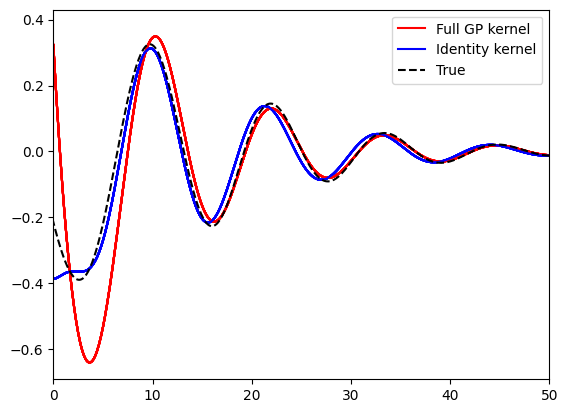

In [595]:
num_samples, num_dim = samples.shape

num_draws = 10

indices = np.random.choice(np.arange(num_samples), size=num_draws, replace=False)

ell, m = 2, 2
posterior_signals = np.zeros((num_draws, len(analysis_times)), dtype=complex)
posterior_signals_ = np.zeros((num_draws, len(analysis_times)), dtype=complex)

for i, idx in enumerate(indices):
    posterior_signals[i] = qnm_model(analysis_times, t0, samples[idx], qnm_list, spherical_modes, Mf_0, chif_mag_0)[(ell, m)]
    posterior_signals_[i] = qnm_model(analysis_times, t0, samples_[idx], qnm_list, spherical_modes, Mf_0, chif_mag_0)[(ell, m)]

    plt.plot(analysis_times, np.real(posterior_signals[i]), label='Full GP kernel' if i==0 else None, color='r')
    plt.plot(analysis_times, np.real(posterior_signals_[i]), label='Identity kernel' if i==0 else None, color='b')

plt.plot(sim_main.times, np.real(sim_main.h[ell,m]), label='True', color='black', ls='--')

plt.xlim(0, 50)
plt.legend()
plt.show()


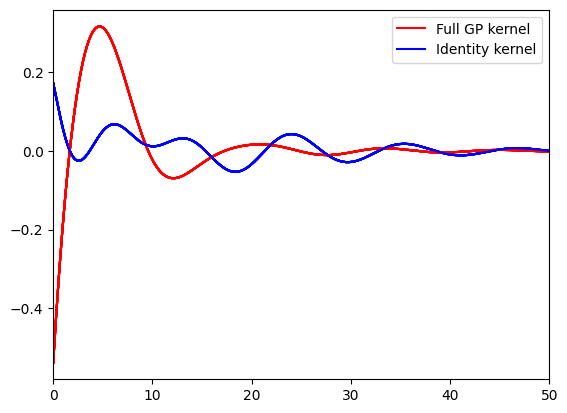

In [596]:
num_samples, num_dim = samples.shape

num_draws = 10

indices = np.random.choice(np.arange(num_samples), size=num_draws, replace=False)

ell, m = 2, 2
posterior_signals = np.zeros((num_draws, len(analysis_times)), dtype=complex)
posterior_signals_ = np.zeros((num_draws, len(analysis_times)), dtype=complex)

data = np.interp(analysis_times, sim_main.times, np.real(sim_main.h[ell,m]))

for i, idx in enumerate(indices):
    posterior_signals[i] = qnm_model(analysis_times, t0, samples[idx], qnm_list, spherical_modes, Mf_0, chif_mag_0)[(ell, m)]
    posterior_signals_[i] = qnm_model(analysis_times, t0, samples_[idx], qnm_list, spherical_modes, Mf_0, chif_mag_0)[(ell, m)]

    plt.plot(analysis_times, data - np.real(posterior_signals[i]), label='Full GP kernel' if i==0 else None, color='r')
    plt.plot(analysis_times, data- np.real(posterior_signals_[i]), label='Identity kernel' if i==0 else None, color='b')

plt.xlim(0, 50)
plt.legend()
plt.show()